# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. Add the Columbia_E4511 folder to your google drive
3. For homework, you will work on this entire notebook for your own targets. Download them here:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

## Mount your drive where you have the Columbia_E4511 folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install packages

In [ ]:
! pip install molvs

In [ ]:
# thanks to https://web.navan.dev/posts/2020-07-01-Install-rdkit-colab/
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
rdkit is already installed


In [ ]:
sys.path.append('/content/drive/MyDrive/Columbia_E4511/AMPL_EDA')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/root/miniconda/lib/python3.7/site-packages',
 '/content/drive/MyDrive/Columbia_E4511/AMPL_EDA']

## Load packages

In [ ]:
%matplotlib inline
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
import struct_utils
import curate_data
import dist_metrics

# visualize compound structures
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

# visualize data
import seaborn as sns
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

## Load data

In [ ]:
'''import requests
url = 'https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/DTC_SLC6A3.csv'
res = requests.get(url, allow_redirects=True)
with open('DTC_SLC6A3.csv','wb') as file:
    file.write(res.content)
DTC_GIT= pd.read_csv('DTC_SLC6A3.csv',sep=',',header=0)
'''

"import requests\nurl = 'https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/DTC_SLC6A3.csv'\nres = requests.get(url, allow_redirects=True)\nwith open('DTC_SLC6A3.csv','wb') as file:\n    file.write(res.content)\nDTC_GIT= pd.read_csv('DTC_SLC6A3.csv',sep=',',header=0)\n"

In [ ]:
chembl = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/CHEMBL.csv")
dtc = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/DTC_SLC6A3.csv")
excape = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/ExCape-db.csv")

# Examine data
- what molecular (and other) identifiers exist for compounds from each database?
- what assay response types are there in each file?
- think about how we might combine these data sources together

In [ ]:
# chembl data come from experiments
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces
print(chembl.shape)

(8031, 45)


In [ ]:
chembl.head() #smiles

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4095847,NaN,0,397.53,0,4.45,1q,c1ccc(CC2CCN(CCn3nnnc3-c3cccc4ccccc34)CC2)cc1,IC50,'>',10000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN
1,CHEMBL4099475,NaN,0,403.53,0,3.89,2c,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1,IC50,'=',5040.0,nM,5.30,NaN,NaN,UO_0000065,13.13,0.24,1.41,8.29,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN
2,CHEMBL4072303,NaN,0,487.97,0,2.22,15,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...,Inhibition,'=',36.0,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4011334,"Inhibition of [3H]WIN35,428 binding to recombi...",B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4007505,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN
3,CHEMBL272074,NaN,0,326.44,0,3.2,rac-6i,CCN(CC)C(=O)C1(c2ccccc2)CC1CNCc1ccco1,IC50,'>',10000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL932890,Inhibition of human DAT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1143218,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None,NaN
4,CHEMBL270607,NaN,0,399.92,0,3.77,9n,CNCc1cc(C(=O)N2CCN(C3CC3)CC2)ccc1Oc1cccc(Cl)c1,Ki,'=',7000.0,nM,5.16,NaN,NaN,UO_0000065,12.89,0.25,1.38,11.5,False,CHEMBL948194,Binding affinity to human DAT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1141555,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None,NaN


In [ ]:
chembl.Standard_Type.value_counts()# assay response types

IC50                    3367
Ki                      3031
Inhibition              1157
Activity                 180
Ratio                     76
                        ... 
Ratio IC50                 2
Affinity                   1
INH                        1
Selectivity ratio          1
Discrimination ratio       1
Name: Standard_Type, Length: 21, dtype: int64

## Exercise: Explore datasets
- load dtc and excape datasets with pandas
- explore the dataframes
- answer questions below

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?

* pIC50 = -log_10(IC50)

What other information might be useful?

In [ ]:
dtc.columns = dtc.columns.str.replace(' ','_') # get rid of annoying spaces
print(dtc.shape)

(7301, 33)


In [ ]:
dtc.head() #Standard_inchi_key

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments
0,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,12213053.0,IC50,=,12.30,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Displacement of [3H]WIN-35428 from Dopamine Tr...,Mazindol analogues as potential inhibitors of ...,J. Med. Chem.,PUBLICATION,NaN
1,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,12213053.0,IC50,=,91.00,NM,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of dopamine uptake in HEK cells exp...,Mazindol analogues as potential inhibitors of ...,J. Med. Chem.,PUBLICATION,NaN
2,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,12213053.0,KI,=,23.10,NM,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Displacement of [125I]- RTI-55 from Dopamine t...,Mazindol analogues as potential inhibitors of ...,J. Med. Chem.,PUBLICATION,NaN
3,CHEMBL14144,AAEKULYONKUBOZ-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,14971892.0,KI,=,5.25,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In vitro binding affinity against human dopami...,"Synthesis, radiosynthesis, and biological eval...",J. Med. Chem.,PUBLICATION,NaN
4,CHEMBL3323101,AAHLCKVWZXFMPB-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,25050161.0,IC50,=,4.50,NM,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Displacement of [3H]WIN 35,428 from human DAT ...",NaN,ACS Med. Chem. Lett.,PUBLICATION,NaN


In [ ]:
dtc.standard_type.value_counts()# assay response types

IC50                    3050
KI                      2985
INHIBITION               851
ACTIVITY                 118
RATIO                     76
                        ... 
EFFICACY                   2
SELECTIVITY RATIO          1
INH                        1
DISCRIMINATION RATIO       1
AFFINITY                   1
Name: standard_type, Length: 21, dtype: int64

In [ ]:
excape.columns = excape.columns.str.replace(' ','_') # get rid of annoying spaces
print(excape.shape)
excape.head()#Ambit_InchiKey	
# 

(111836, 11)


,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,CHSINHUYLALJPT-UHFFFAOYNA-N,9549512,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,N1(C2CCCCCC2)CCNCC1
1,SBIGSHCJXYGFMX-UHFFFAOYNA-N,1778877,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O(C(=O)CCCCCCCC=C)C
2,STHIZMRUXPMSCW-UHFFFAOYNA-N,123435,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O1CCNCCOCCOCCNCC1
3,XVFVMXHZBURBPL-UHFFFAOYNA-N,3245471,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O=C1N(CN2CCCCC2)CCC1
4,AVNGLLNZZQWRFA-UHFFFAOYNA-N,16060801,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O=C1CCN(CCCCCCC)C=C1


In [ ]:
excape.pXC50.value_counts()# assay response values only ic and ec50

7.80000    40
8.00000    38
7.00000    36
5.00000    32
7.60000    31
           ..
6.01412     1
8.55284     1
7.63264     1
7.34008     1
5.80743     1
Name: pXC50, Length: 1253, dtype: int64

# EDA: assay data responses
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [ ]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4095847,NaN,0,397.53,0,4.45,1q,c1ccc(CC2CCN(CCn3nnnc3-c3cccc4ccccc34)CC2)cc1,IC50,'>',10000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN
1,CHEMBL4099475,NaN,0,403.53,0,3.89,2c,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1,IC50,'=',5040.0,nM,5.30,NaN,NaN,UO_0000065,13.13,0.24,1.41,8.29,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN
2,CHEMBL4072303,NaN,0,487.97,0,2.22,15,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...,Inhibition,'=',36.0,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4011334,"Inhibition of [3H]WIN35,428 binding to recombi...",B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4007505,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN
3,CHEMBL272074,NaN,0,326.44,0,3.2,rac-6i,CCN(CC)C(=O)C1(c2ccccc2)CC1CNCc1ccco1,IC50,'>',10000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL932890,Inhibition of human DAT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1143218,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None,NaN
4,CHEMBL270607,NaN,0,399.92,0,3.77,9n,CNCc1cc(C(=O)N2CCN(C3CC3)CC2)ccc1Oc1cccc(Cl)c1,Ki,'=',7000.0,nM,5.16,NaN,NaN,UO_0000065,12.89,0.25,1.38,11.5,False,CHEMBL948194,Binding affinity to human DAT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1141555,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None,NaN


In [ ]:
print('CHEMBL',chembl.Standard_Units.unique()) #type of variable are the data responses
print('\nDTC', dtc.standard_units.unique())

CHEMBL ['nM' '%' nan 'uM' 'ug.mL-1']

DTC ['NM' nan '%' 'UG.ML-1']


### **Curation step**: change units to be the same for all responses

In [ ]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)


## EDA: Summarize, describe, plot data for analysis

In [ ]:
# summary statistics
chembl=chembl.replace('None',np.nan)
chembl.describe()

,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Source_ID,Document_Year,Standard_Value_nM
count,8031.000000,8006.000000,7860.000000,7860.000000,6.029000e+03,3870.000000,3724.000000,3665.000000,3665.000000,3661.000000,8031.000000,6097.000000,6.029000e+03
mean,0.810360,349.454393,0.232443,3.510851,5.155393e+11,6.650450,20.598550,0.413675,2.644917,36.866878,6.133109,2009.320485,5.155393e+11
std,1.584411,134.682903,0.528646,1.669411,1.620094e+13,1.130844,5.571761,0.111730,1.594709,49.883078,10.639061,5.132397,1.620094e+13
min,0.000000,32.050000,0.000000,-13.050000,-6.390000e+01,4.010000,3.080000,0.120000,-4.180000,2.670000,1.000000,1979.000000,-6.390000e+01
25%,0.000000,279.860000,0.000000,2.660000,2.300000e+01,5.750000,16.755000,0.330000,1.650000,14.430000,1.000000,2007.000000,2.300000e+01
50%,0.000000,322.240000,0.000000,3.590000,1.500000e+02,6.570000,20.380000,0.410000,2.660000,21.770000,1.000000,2009.000000,1.540000e+02
75%,0.000000,395.430000,0.000000,4.490000,2.250000e+03,7.460000,24.450000,0.490000,3.750000,32.930000,15.000000,2013.000000,2.250000e+03
max,4.000000,2296.970000,4.000000,12.390000,9.120108e+14,10.230000,56.250000,1.040000,7.530000,298.070000,54.000000,2020.000000,9.120108e+14


- **Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries**


In [ ]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

In [ ]:
chembl.describe()

,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Source_ID,Document_Year,Standard_Value_nM
count,8031.000000,8006.000000,7860.000000,7860.000000,6.029000e+03,3870.000000,3724.000000,3665.000000,3665.000000,3661.000000,8031.000000,6097.000000,6.029000e+03
mean,0.810360,349.454393,0.232443,3.510851,5.155393e+11,6.650450,20.598550,0.413675,2.644917,36.866878,6.133109,2009.320485,5.155393e+11
std,1.584411,134.682903,0.528646,1.669411,1.620094e+13,1.130844,5.571761,0.111730,1.594709,49.883078,10.639061,5.132397,1.620094e+13
min,0.000000,32.050000,0.000000,-13.050000,-6.390000e+01,4.010000,3.080000,0.120000,-4.180000,2.670000,1.000000,1979.000000,-6.390000e+01
25%,0.000000,279.860000,0.000000,2.660000,2.300000e+01,5.750000,16.755000,0.330000,1.650000,14.430000,1.000000,2007.000000,2.300000e+01
50%,0.000000,322.240000,0.000000,3.590000,1.500000e+02,6.570000,20.380000,0.410000,2.660000,21.770000,1.000000,2009.000000,1.540000e+02
75%,0.000000,395.430000,0.000000,4.490000,2.250000e+03,7.460000,24.450000,0.490000,3.750000,32.930000,15.000000,2013.000000,2.250000e+03
max,4.000000,2296.970000,4.000000,12.390000,9.120108e+14,10.230000,56.250000,1.040000,7.530000,298.070000,54.000000,2020.000000,9.120108e+14


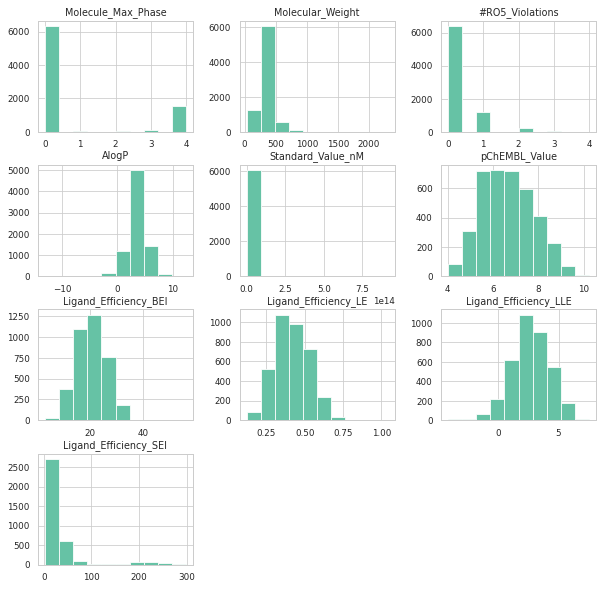

In [ ]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types / assays represented in the value columns. Let's split those up:**

Standard_Type,% Ctrl,% Inhibition of Control Specific Binding (Mean n=2),Activity,Affinity,Discrimination ratio,Displacement,EC50,Efficacy,IC5,IC50,INH,Inhibition,Kd,Ki,Log 1/C,Ratio,Ratio IC50,Ratio Ki,Selectivity ratio,pKD
count,7.000000,8.000000,113.000000,1.00,1.00,4.0,30.000000,2.00000,4.00000,2033.000000,1.0,857.000000,21.000000,1.783000e+03,46.000000,72.000000,1.0,2.00000,1.00,52.000000
mean,78.285714,17.612500,373.553982,5.28,0.25,200.0,2076.497667,75.60000,4181.00000,6045.760058,16000.0,31.211301,7503.390476,1.380877e+12,6.528732,6.224375,15.0,31.25000,0.62,7.099231
std,28.703741,12.021105,1938.849432,NaN,NaN,0.0,4515.171864,22.91026,4834.75432,22786.390229,NaN,32.567748,11561.751403,2.675066e+13,0.602333,12.991079,NaN,22.98097,NaN,0.779474
min,28.000000,2.200000,0.000000,5.28,0.25,200.0,12.500000,59.40000,48.00000,0.002000,16000.0,-63.900000,1.200000,0.000000e+00,5.210000,0.020000,15.0,15.00000,0.62,5.660000
25%,62.000000,5.475000,7.000000,5.28,0.25,200.0,234.187500,67.50000,280.50000,90.000000,16000.0,5.210000,200.000000,4.500000e+01,6.105000,0.985000,15.0,23.12500,0.62,6.340000
50%,91.000000,20.950000,21.000000,5.28,0.25,200.0,577.500000,75.60000,3338.00000,800.000000,16000.0,25.800000,1080.000000,4.610000e+02,6.615000,1.750000,15.0,31.25000,0.62,7.260000
75%,99.500000,26.775000,64.000000,5.28,0.25,200.0,1045.000000,83.70000,7238.50000,5923.333333,16000.0,50.000000,9300.000000,3.580000e+03,6.910000,4.525000,15.0,39.37500,0.62,7.642500
max,106.000000,31.600000,17700.000000,5.28,0.25,200.0,22908.680000,91.80000,10000.00000,744000.000000,16000.0,105.000000,42000.000000,9.120108e+14,7.800000,76.800000,15.0,47.50000,0.62,8.420000


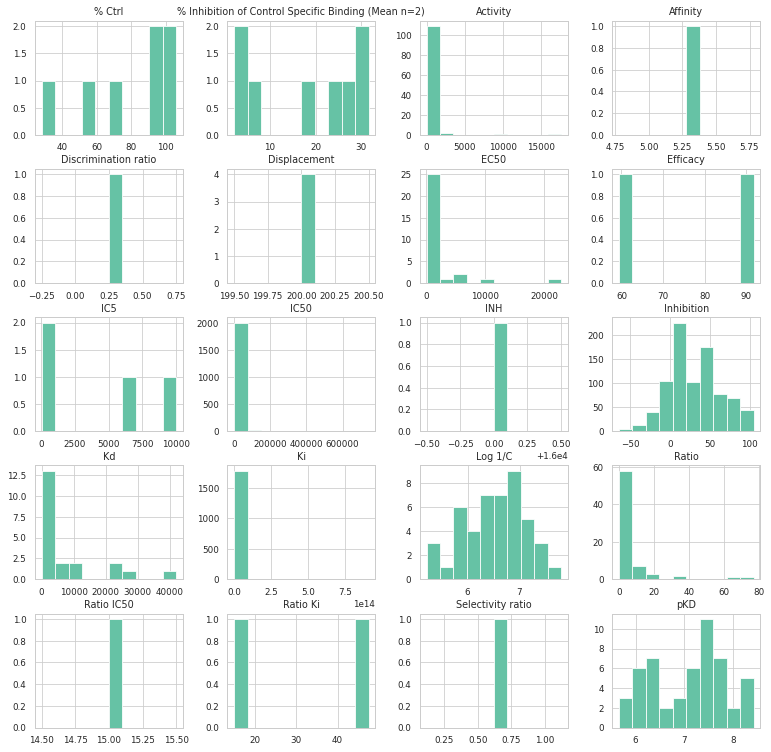

In [ ]:
# examine standard values and pChembl values per standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

- **What do you notice about the standard values?**

Standard_Type,EC50,IC50,Kd,Ki
count,25.000000,1642.000000,21.000000,1470.000000
mean,6.397000,6.488622,5.966667,6.732454
std,0.791579,1.106943,1.166218,1.117893
min,4.640000,4.040000,4.380000,4.010000
25%,5.950000,5.620000,5.030000,5.760000
50%,6.400000,6.440000,5.970000,6.695000
75%,7.025000,7.237500,6.700000,7.550000
max,7.900000,10.230000,8.920000,9.920000


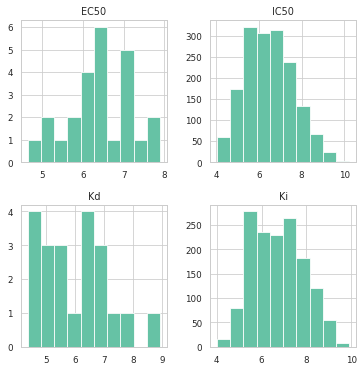

In [ ]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way

In [ ]:
dtc['pDTC_Value'] = np.where(dtc.standard_units == 'NM',
                                           -np.log10(dtc.standard_value/1000000000),
                                           dtc.standard_value)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,111836.000000,5292.000000,1.118360e+05,111836.000000,111836.0
mean,6988.297802,6.795182,4.456107e+05,9618.775636,4060.0
std,2858.314323,1.218889,6.742001e+04,79.681560,0.0
min,6531.000000,2.140000,4.933600e+04,9606.000000,4060.0
25%,6531.000000,5.850000,4.497680e+05,9606.000000,4060.0
50%,6531.000000,6.790000,4.497680e+05,9606.000000,4060.0
75%,6531.000000,7.700000,4.497680e+05,9606.000000,4060.0
max,24898.000000,11.700000,1.367804e+06,10116.000000,4060.0


Text(0.5, 1.0, 'Excape PXC50 Distribution')

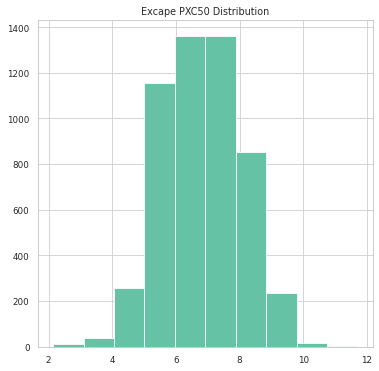

In [ ]:
display(excape.describe())
excape.pXC50.hist(figsize=(6,6))
plt.title('Excape PXC50 Distribution')

standard_type,ACTIVITY,AFFINITY,Activity,DISCRIMINATION RATIO,DISPLACEMENT,EC50,EFFICACY,IC5,IC50,INH,INHIBITION,Inhibition,KD,KI,Ki,LOG 1/C,PKD,RATIO,RATIO KI,SELECTIVITY RATIO
count,88.000000,1.00,4.000000,1.00,4.0,10.000000,2.00000,4.00000,1781.000000,1.0,638.000000,6.000000,20.00000,1.690000e+03,46.000000,46.000000,52.000000,72.000000,2.00000,1.00
mean,374.521970,5.28,88.375000,0.25,200.0,4053.848000,75.60000,4181.00000,4716.506430,16000.0,31.200959,41.450000,7868.56000,1.456867e+12,3622.441957,6.528732,7.099231,6.224375,31.25000,0.62
std,2179.142973,NaN,79.245794,NaN,0.0,7002.985707,22.91026,4834.75432,20755.313775,NaN,31.555676,22.530313,11737.20002,2.747525e+13,18804.518572,0.602333,0.779474,12.991079,22.98097,NaN
min,0.000000,5.28,13.500000,0.25,200.0,24.800000,59.40000,48.00000,0.002000,16000.0,-63.900000,16.200000,1.20000,1.200000e-01,0.910000,5.210000,5.660000,0.020000,15.00000,0.62
25%,5.000000,5.28,50.625000,0.25,200.0,537.750000,67.50000,280.50000,72.000000,16000.0,6.000000,25.875000,293.75000,5.012000e+01,22.200000,6.105000,6.340000,0.985000,23.12500,0.62
50%,13.000000,5.28,70.000000,0.25,200.0,991.000000,75.60000,3338.00000,540.000000,16000.0,24.550000,40.000000,2290.00000,5.011900e+02,112.000000,6.615000,7.260000,1.750000,31.25000,0.62
75%,36.500000,5.28,107.750000,0.25,200.0,4377.500000,83.70000,7238.50000,4300.000000,16000.0,50.000000,50.000000,9975.00000,4.130500e+03,1000.000000,6.910000,7.642500,4.525000,39.37500,0.62
max,17700.000000,5.28,200.000000,0.25,200.0,22908.680000,91.80000,10000.00000,744000.000000,16000.0,103.000000,78.000000,42000.00000,9.120108e+14,128000.000000,7.800000,8.420000,76.800000,47.50000,0.62


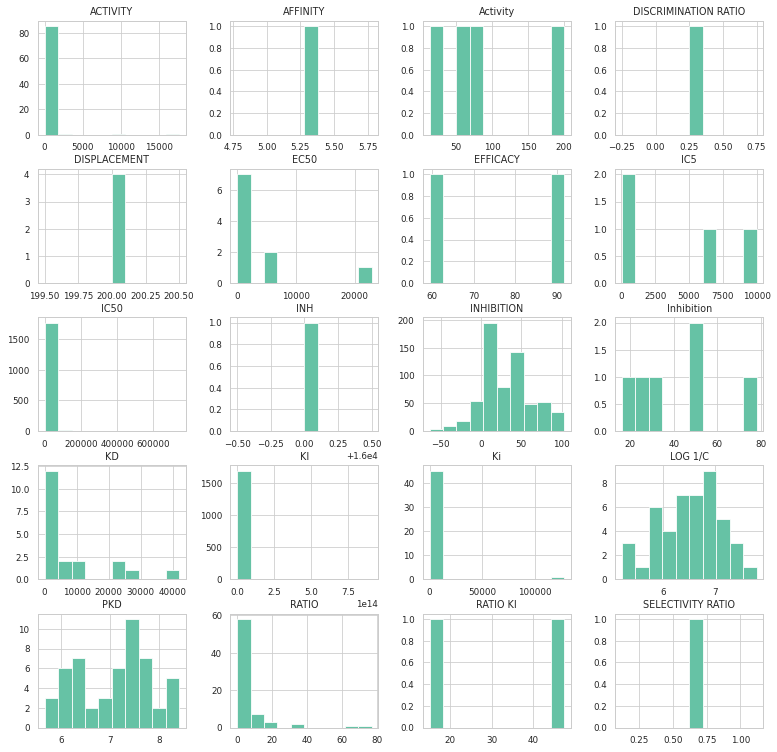

In [ ]:
dtc_types=dtc.pivot_table(index = 'compound_id', columns = 'standard_type', values='standard_value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(13,13))
plt.show()

In [1]:
# Use p_DCT value 
dtc_types=dtc.pivot_table(index = 'compound_id', columns = 'standard_type', values='pDTC_value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(13,13), )
plt.show()
#IC50 looks normal


NameError: ignored

## EDA & Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

## Exercise: analyze & discuss
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

# EDA: Compounds

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets / excel
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

In [ ]:
# open file from pubchem ID exchange service
dtc_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/dtc_smiles_file", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL336100,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F
1,CHEMBL336100,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F
2,CHEMBL336100,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F
3,CHEMBL14144,CN1C2CCC1C(C(C2)C3=CC=C(C=C3)Cl)C(=O)OC4=CC=CC=C4
4,CHEMBL3323101,CN1CC(C2=CC=CC=C2C1)C3=CC4=C(C=C3)NC=C4


In [ ]:
# map chembl id to smiles using a dict
# zip the above two series as a dictionary and map smiles according to compound id
dtc['SMILES'] = dtc['compound_id'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [ ]:
# what's missing?
print("No ChemblID in DTC:", sum(dtc['compound_id'].isna()))
print("No SMILES from ChemblID in DTC:", sum(dtc.SMILES.isna()))

No ChemblID in DTC: 16
No SMILES from ChemblID in DTC: 117


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [ ]:
# try it yourself here

In [ ]:
NO_SMILES = dtc[dtc['SMILES'].isna()]
NO_SMILES['smiles'] = NO_SMILES['target_id'].map(dict(zip(dtc.target_id,dtc.SMILES)))
dtc.loc[dtc.pubmed_id==10755640]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value,SMILES
25,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,10755640.0,KI,=,1.53,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.815309,NaN


## EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

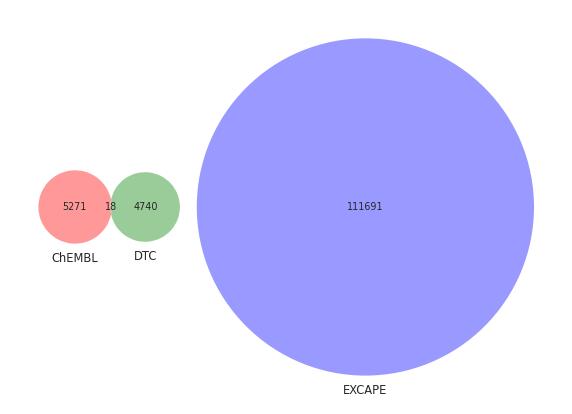

In [ ]:
# overlaps from SMILES strings
mpv.venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

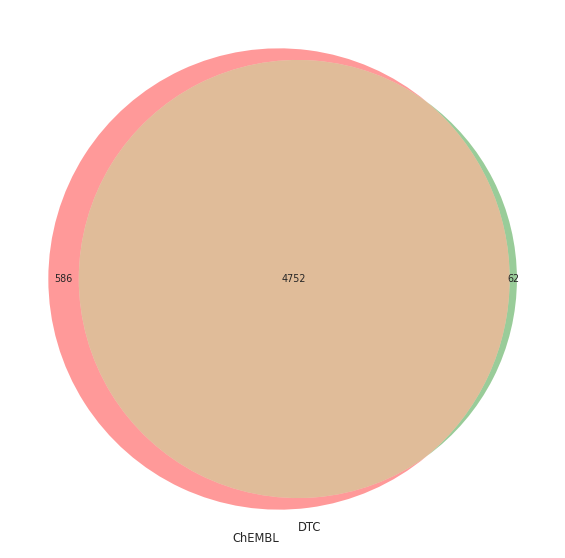

In [ ]:
# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists
mpv.venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.compound_id)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

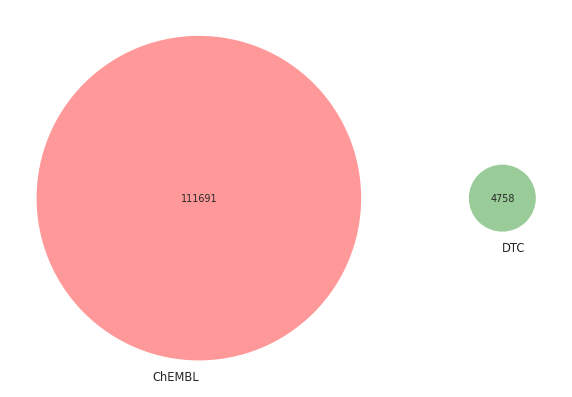

In [ ]:
mpv.venn2([set(excape.SMILES), set(dtc.SMILES)], set_labels=['ChEMBL','DTC']);

## **Curation step:** Standardize smiles strings, drop rows without base smiles

In [ ]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(struct_utils.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))



8031
5289
5251


In [ ]:
chembl[chembl.base_rdkit_smiles=='']

In [ ]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

In [ ]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()] # DROP ALL EMPTY rdkitsmiles

## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [ ]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(struct_utils.base_smiles_from_smiles)

In [ ]:
excape.head()

In [ ]:
print(len(excape.SMILES))
print(len(excape.SMILES.unique()))
print(len(excape.base_rdkit_smiles.unique()))


111836
111691
111601


In [ ]:
excape[excape.base_rdkit_smiles.duplicated(keep=False)].sort_values('base_rdkit_smiles') 
# we can see same rdkit smiles but smiles different

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
6747,DAPCKNJKGASBHF-UHFFFAOYNA-N,5389047,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,S1C(=N(O)=CC=2SC=CC2)C(N(C1=S)C)(C)C,
19214,KZGDMAUPNOGKOX-UHFFFAOYNA-N,5389051,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,S1C(=N(O)=CC2=CC=CN=C2)C(N(C1=S)C)(C)C,
20603,NWRFMJSGZCVERY-UHFFFAOYNA-N,9551615,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,S1C(=N(O)=CC=2C=CC=CC2)C(N(C1=S)C)(C)C,
15659,AJXKLHFIQDVGJG-UHFFFAOYNA-N,5389055,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,S1C(C(N(C1=S)C)=N(O)=CC2=CC=CN=C2)(C)C,
85382,ZYWULSRYZLJMEE-UHFFFAOYNA-N,371204,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,ON1=2C(CC3=C(C1)C(OC)=C(OC)C=C3)C=4C(CC2)=CC(O...,
...,...,...,...,...,...,...,...,...,...,...,...,...
14308,ZWLWOTHDIGRTNE-UHFFFAOYNA-N,CHEMBL150045,6531,A,7.10000,chembl20,62820,9606,SLC6A3,4060,C(C1=CC=NC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,c1ccc(C(c2ccccc2)c2ccncc2)cc1
80471,RAQPOZGWANIDQT-UHFFFAOYNA-N,3456,24898,A,8.43180,pubchem,180512,10116,SLC6A3,4060,O(CCN1CCN(CC1)CCCC2=CC=CC=C2)C(C3=CC=CC=C3)C4=...,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1
80472,RAQPOZGWANIDQT-UHFFFAOYNA-N,CHEMBL26320,6531,A,8.43000,chembl20,532579,9606,SLC6A3,4060,C=1C=CC(=CC1)C(C=2C=CC=CC2)OCCN3CCN(CC3)CCCC4=...,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1
22491,RGSVXQJPSWZXOP-UHFFFAOYNA-N,CHEMBL279556,6531,A,8.66000,chembl20,762026,9606,SLC6A3,4060,N1(CCCCC1)C2(CCCCC2)C3=CC=4C(S3)=CC=CC4,c1ccc2sc(C3(N4CCCCC4)CCCCC3)cc2c1


In [ ]:
# drop empty rdkit smilees for excape and dtc
excape=excape.replace('',np.nan)
excape=excape[~excape.base_rdkit_smiles.isna()] # DROP ALL EMPTY rdkitsmiles

In [ ]:

#dtc['base_rdkit_smiles'] = dtc.SMILES.apply(struct_utils.base_smiles_from_smiles)
dtc=dtc.replace('',np.nan)
dtc=dtc[~dtc.base_rdkit_smiles.isna()]

In [ ]:
print(len(dtc.SMILES))
print(len(dtc.SMILES.unique()))
print(len(dtc.base_rdkit_smiles.unique()))

7184
4757
4724


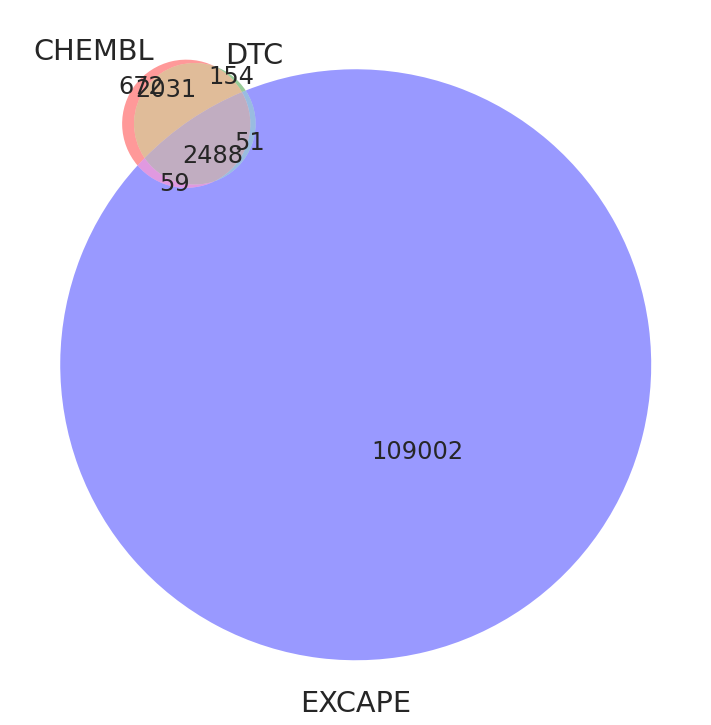

In [ ]:
plt.figure(figsize=(13,13))
mpv.venn3([set(chembl.base_rdkit_smiles),set(dtc.base_rdkit_smiles),set(excape.base_rdkit_smiles)],set_labels=['CHEMBL','DTC','EXCAPE'])


## **Curation step:** Save standardized datasets

In [ ]:
chembl.to_csv("/content/drive/MyDrive/Columbia_E4511/CHEMBL.csv")
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/DTC_SLC6A3.csv")
excape.to_csv("/content/drive/MyDrive/Columbia_E4511/ExCape-db.csv")

## EDA: Examine compound diversity

In [ ]:
import diversity_plots as dp
sns.set_context('poster')

2021-03-10 18:26:06,676 Starting distance matrix calculation for 1000 compounds
2021-03-10 18:26:07,507 Finished calculation of 499500 distances


array([0.88571429, 0.90769231, 0.9047619 , ..., 0.87777778, 0.91011236,
       0.83870968])

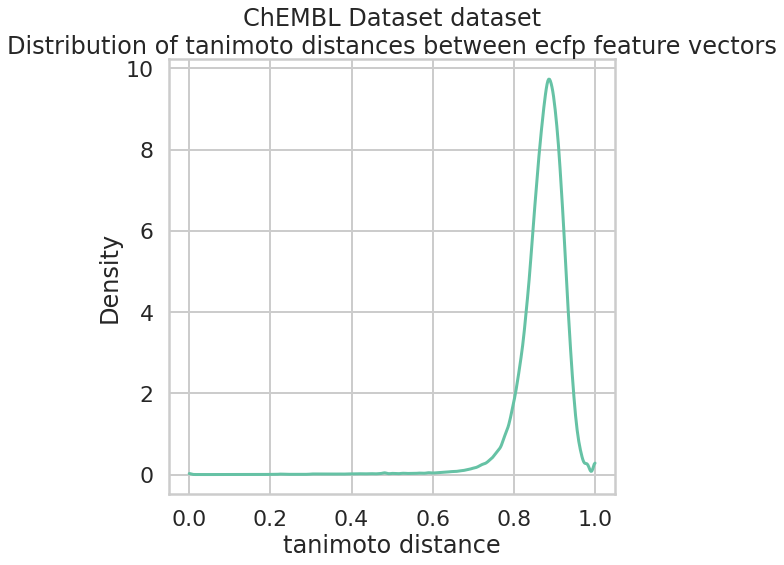

In [ ]:
import random
index = random.sample(list(chembl.index),1000)

dp.plot_tani_dist_distr(chembl.iloc[index], 'base_rdkit_smiles', 'ChEMBL Dataset')

2021-03-10 18:26:26,559 Starting distance matrix calculation for 7931 compounds
2021-03-10 18:27:03,164 Finished calculation of 31446415 distances


array([0.47692308, 0.92307692, 0.9       , ..., 0.91743119, 0.85714286,
       0.86813187])

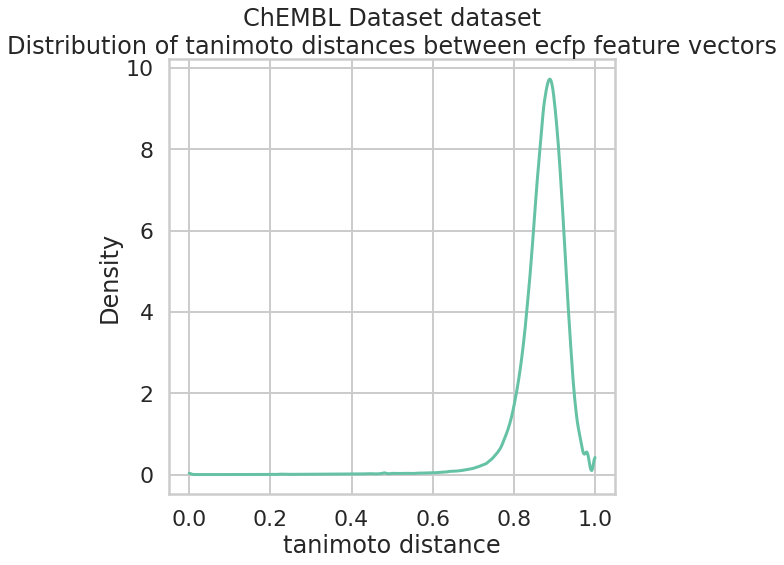

In [ ]:
dp.plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [ ]:
chembl.columns

Index(['Molecule_ChEMBL_ID', 'Molecule_Name', 'Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Compound_Key',
       'Smiles', 'Standard_Type', 'Standard_Relation', 'Standard_Value',
       'Standard_Units', 'pChEMBL_Value', 'Data_Validity_Comment', 'Comment',
       'Uo_Units', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI', 'Potential_Duplicate',
       'Assay_ChEMBL_ID', 'Assay_Description', 'Assay_Type', 'BAO_Format_ID',
       'BAO_Label', 'Assay_Organism', 'Assay_Tissue_ChEMBL_ID',
       'Assay_Tissue_Name', 'Assay_Cell_Type', 'Assay_Subcellular_Fraction',
       'Assay_Parameters', 'Assay_Variant_Accession', 'Assay_Variant_Mutation',
       'Target_ChEMBL_ID', 'Target_Name', 'Target_Organism', 'Target_Type',
       'Document_ChEMBL_ID', 'Source_ID', 'Source_Description',
       'Document_Journal', 'Document_Year', 'Cell_ChEMBL_ID', 'Properties',
       'Standard_Value_nM', 'base_rdkit_smiles'

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


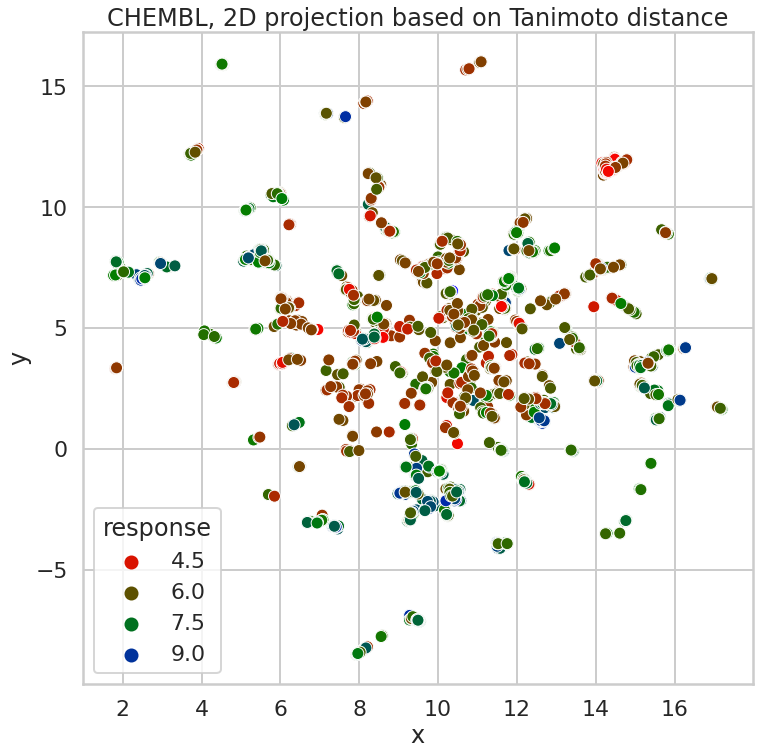

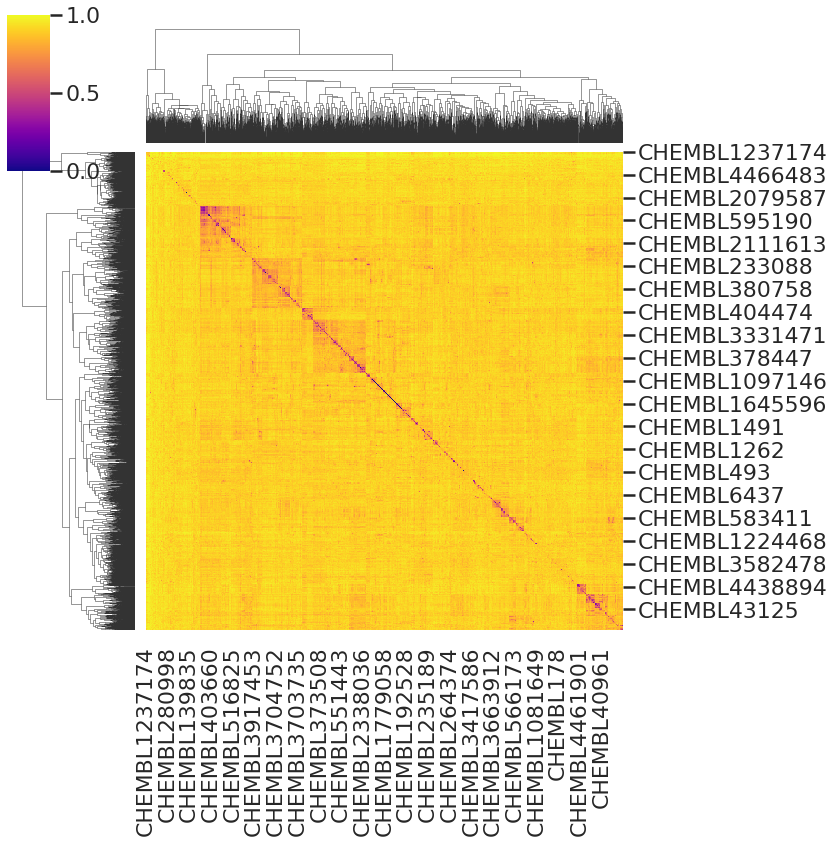

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CHEMBL.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')


## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
    - ECFP split a molecule into layers by looking at atom bonds for each atom with the distance of radius. Each substructure is identified with a number. Increasing radius have different substructure of modelcues and will have differnt identifier.
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

In [ ]:
index = random.sample(list(excape.index),1000)
sub_excape = excape.iloc[index]
sub_excape.to_csv("/content/drive/MyDrive/Columbia_E4511/sub_excape.csv")

2021-03-10 18:42:55,359 Starting distance matrix calculation for 1000 compounds
2021-03-10 18:42:56,534 Finished calculation of 499500 distances


Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


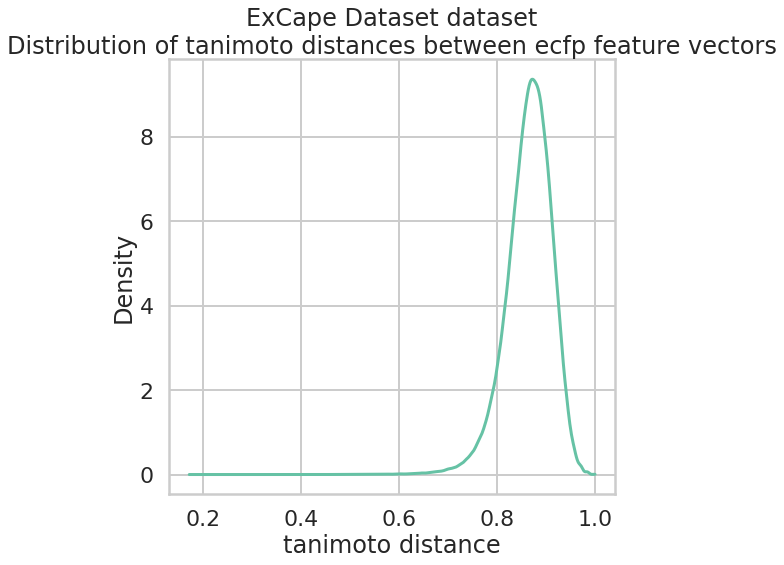

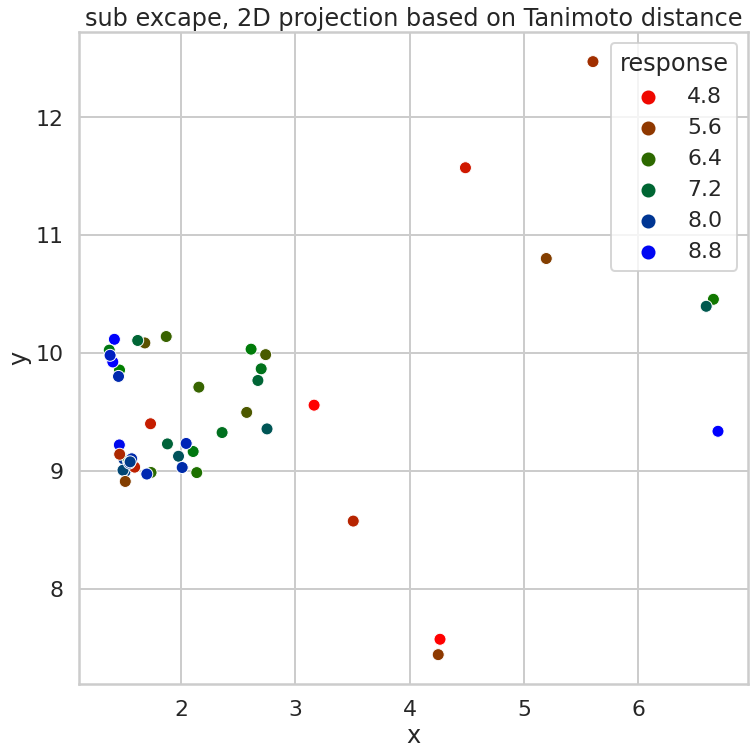

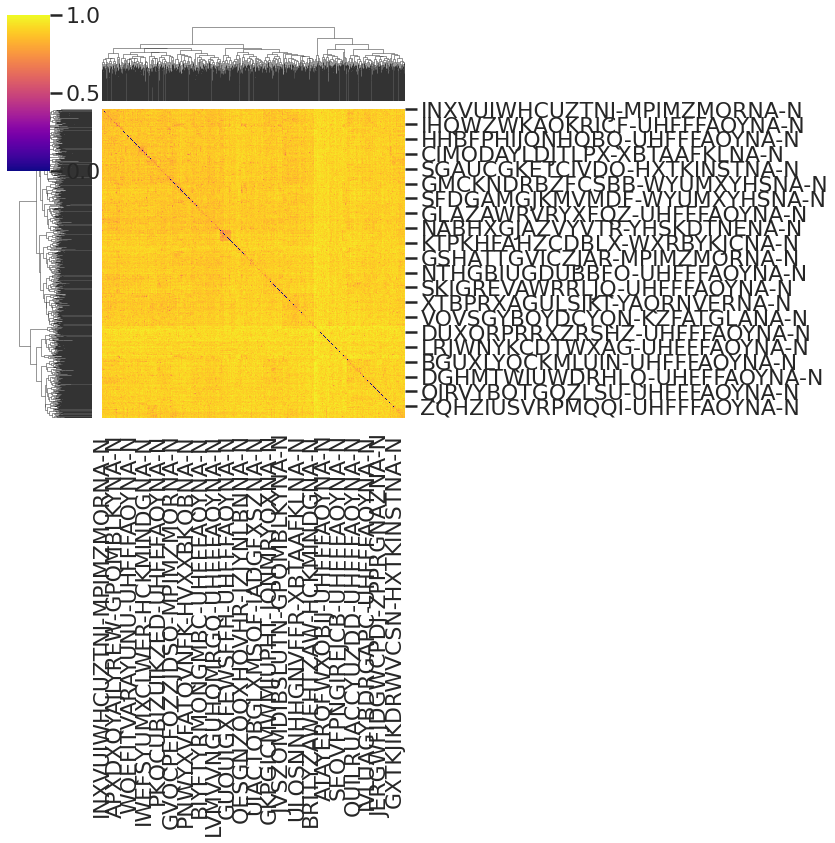

In [ ]:
index = random.sample(list(excape.index),1000)

dp.plot_tani_dist_distr(excape.iloc[index], smiles_col='base_rdkit_smiles', dataset_name='ExCape Dataset')
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/sub_excape.csv', 
                   id_col ='Ambit_InchiKey', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50')

In [ ]:
sum(excape.pXC50.isna())

106544

2021-03-10 16:26:32,549 Starting distance matrix calculation for 1000 compounds
2021-03-10 16:26:33,269 Finished calculation of 499500 distances


Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


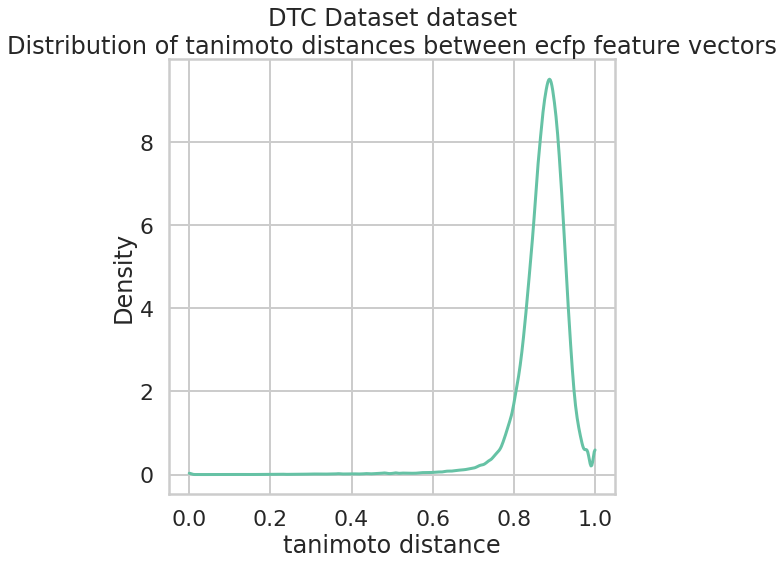

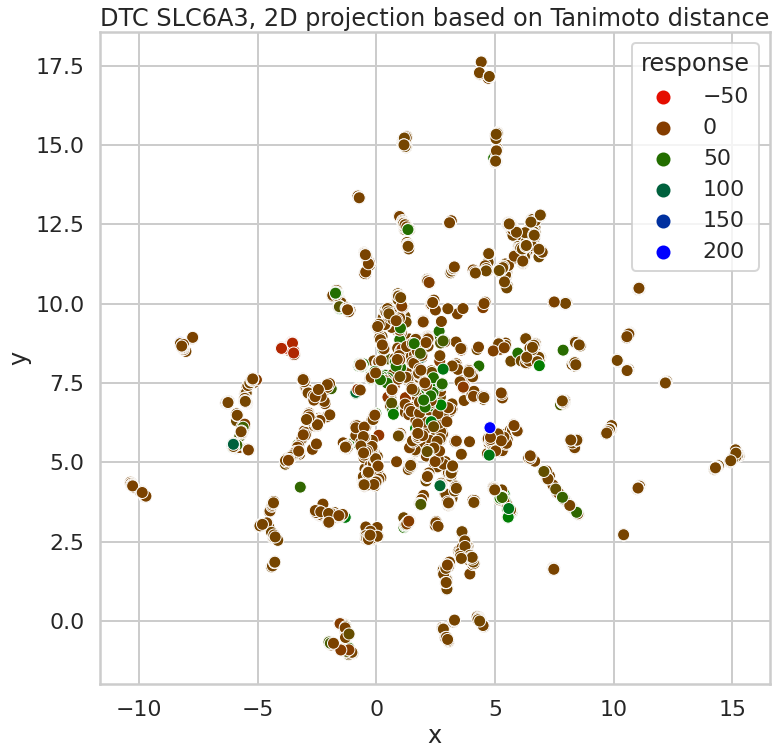

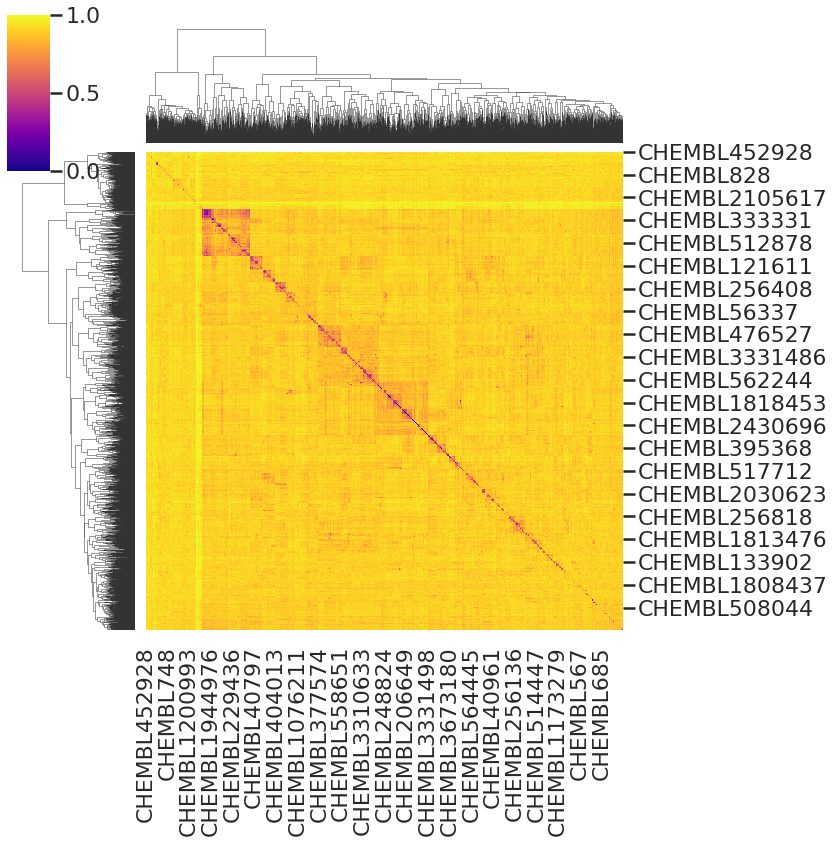

In [ ]:
index = random.sample(list(dtc.index),1000)
dp.plot_tani_dist_distr(dtc.iloc[index], smiles_col='base_rdkit_smiles', dataset_name='DTC Dataset')
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/DTC_SLC6A3.csv', 
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', ecfp_radius=4
                   is_base_smiles=True, response_col = 'pDTC_Value')

2

## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
    -  the atoms that contribute to particular bits in the Morgan fingerprint  within a radius
  - what radius and vector length are used in these functions?
    - 4,300
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?